In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import itertools 
import pandas as pd
from tqdm import tqdm
import seaborn as sns
from scipy import stats
import datajoint as dj
from collections import defaultdict
import pycircstat as pycs
from tqdm import tqdm
import scipy.stats as stats


In [2]:
#setting the address and the username
dj.config['database.host'] = '10.28.0.34'
dj.config['database.user'] = 'celiib'
dj.config['database.password'] = 'newceliipass'
dj.config['safemode']=True
dj.config["display.limit"] = 20


pinky = dj.create_virtual_module('pinky', 'microns_pinky')
ndap100 = dj.create_virtual_module('pinky_nda', 'microns_pinky_nda')
radtune = dj.create_virtual_module('pinky_radtune', 'microns_pinky_radtune')
spattune = dj.create_virtual_module('pinky_spattune', 'microns_pinky_spattune')
fc = dj.create_virtual_module('pinky_fc', 'microns_pinky_fc')


Connecting celiib@10.28.0.34:3306


In [3]:
#demonstrates that all the correlation tables have been fully run
print((len(fc.ContactCorrelationShaft()),
       len(fc.ContactCorrelationHead()),
       len(fc.ContactCorrelationAxon()),
       len(fc.ContactCorrelationSoma()),
       len(fc.ContactCorrelationUnused())))

(484620, 484620, 484620, 484620, 484620)


In [4]:
# segments that have dendrite verteces > restriction threshold

dendrite_labels = ["Apical","Basal","Oblique","Dendrite"]

#dj.U("segment_id").aggr(pinky.CompartmentFinal.ComponentFinal() & [dict(compartment_type=x) for x in dendrite_labels]
#pinky.CompartmentFinal.ComponentFinal() & [dict(compartment_type=x) for x in dendrite_labels] & "n_vertex_indices>500"
excitatory = dj.U("segment_id").aggr(pinky.CompartmentFinal.ComponentFinal() & [dict(compartment_type=x) for x in dendrite_labels] & "n_vertex_indices>500",
                       dendrite_vertex_count="sum(n_vertex_indices)")

orphan = dj.U("segment_id").aggr(pinky.CompartmentOrphan.ComponentOrphan() & [dict(compartment_type=x) for x in dendrite_labels] & "n_vertex_indices>500",
                       dendrite_vertex_count="sum(n_vertex_indices)")

restriction_threshold = 15000
dendrite_restriction = ((excitatory & "dendrite_vertex_count >" + str(restriction_threshold)).proj() + 
                            (orphan & "dendrite_vertex_count >" + str(restriction_threshold)).proj())

dendrite_restriction

segment_id segment id unique within each Segmentation
648518346341371119
648518346349386137
648518346349470171
648518346349471156
648518346349471500
648518346349471562
648518346349471565
648518346349471910
648518346349472574
648518346349472601


In [5]:
# Exclude synapses, segments and restrict by functional confidence 

contact = pinky.SkeletonContact & pinky.CurrentSegmentation
synapse = (pinky.Synapse - pinky.SynapseExclude) & pinky.CurrentSegmentation

segment = (pinky.Segment - pinky.SegmentExclude) & pinky.CurrentSegmentation
soma = (pinky.AllenSoma - pinky.SegmentExclude) & pinky.CurrentSegmentation

## Orientation / Direction / Von fit correlation

In [6]:
# obtain a list of all keys in fc.ContactCorrelation
df = pd.DataFrame(fc.ContactCorrelation.fetch())
attrs = []
for col in df.columns:
    attrs.append(str(col))


In [8]:
fc.ContactCorrelationShaft()

segmentation segmentation id,segment_id segment id unique within each Segmentation,segment_b id of the postsynaptic neuron,n_seg_a n_presyns contacting onto segment_id,n_seg_b n_presyns contacting onto segment_b,n_seg_shared n_presyns contacting onto both segment_id and segment_b,n_seg_union n_presyns contacting either segment_id or segment_b,n_seg_shared_converted n_presyns contacting onto both and converting on at least 1 postsyn,n_seg_a_converted n_presyns contacting onto both and converting on postsyna a,n_seg_a_converted_prop proportion of n_presyns contacting onto both which convert at least onto postsyna a,n_seg_b_converted n_presyns contacting onto both and converting on postsyna b,n_seg_b_converted_prop proportion of n_presyns contacting onto both which convert at least onto postsyna b,binary_conversion_pearson pearson correlation for binary n_synapse/n_contact rate,binary_conversion_cosine cosine similarity correlation for binary n_synapse/n_contact rate,binary_conv_jaccard_ones_ratio a / (a + b + c + d) for jaccard similarity of binary conversion rate,binary_conv_jaccard_matching_ratio ( a + d )/ (a + b + c + d) for jaccard similarity of binary conversion rate,conversion_pearson Pearson correlation for n_synapse/n_contact rate,conversion_cosine cosine similarity for n_synapse/n_contact rate,density_pearson Pearson correlation for n_synapse/postsyn_length rate,density_cosine cosine similarity for n_synapse/postsyn_length rate,synapse_volume_mean_pearson Pearson correlation for mean of synaptic volume,synapse_volume_mean_cosine cosine similarity for mean of synaptic volume,synapse_vol_density_pearson Pearson correlation for n_synapses*synapse_sizes_mean/postsyn_length rate,synapse_vol_density_cosine cosine similarity for n_synapses*synapse_sizes_mean/postsyn_length rate,binary_conversion_pearson_converted pearson correlation for binary n_synapse/n_contact rate for axon group with at least 1 conversion,binary_conversion_cosine_converted cosine similarity correlation for binary n_synapse/n_contact rate for axon group with at least 1 conversion,binary_conv_jaccard_ones_ratio_converted a / (a + b + c + d) for jaccard similarity of binary conversion rate with at least 1 conversion,binary_conv_jaccard_matching_ratio_converted ( a + d )/ (a + b + c + d) for jaccard similarity of binary conversion rate with at least 1 conversion,conversion_pearson_converted Pearson correlation for n_synapse/n_contact rate for axon group with at least 1 conversion,conversion_cosine_converted cosine similarity for n_synapse/n_contact rate for axon group with at least 1 conversion,density_pearson_converted Pearson correlation for n_synapse/postsyn_length rate for axon group with at least 1 conversion,density_cosine_converted cosine similarity for n_synapse/postsyn_length rate for axon group with at least 1 conversion,synapse_volume_mean_pearson_converted Pearson correlation for mean of synaptic volume for axon group with at least 1 conversion,synapse_volume_mean_cosine_converted cosine similarity for mean of synaptic volume for axon group with at least 1 conversion,synapse_vol_density_pearson_converted Pearson correlation for n_synapses*synapse_sizes_mean/postsyn_length rate for axon group with at least 1 conversion,synapse_vol_density_cosine_converted cosine similarity for n_synapses*synapse_sizes_mean/postsyn_length rate for axon group with at least 1 conversion
3,648518346341353058,648518346341353574,65,9,0,74,0,0,nan,0,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
3,648518346341353058,648518346341353607,65,53,0,118,0,0,nan,0,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
3,648518346341353058,648518346341353788,65,0,0,65,0,0,nan,0,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
3,648518346341353058,648518346341354313,65,2,0,67,0,0,nan,0,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,na

In [9]:
radtune.BestVonFit.Unit & segment & tuned & 'von_p_value <= 0.001'

NameError: name 'tuned' is not defined

In [10]:
radtune.BestVonCorr()

von_hash1 unique hash for combination of sta analysis methods,von_hash2 unique hash for combination of sta analysis methods,segmentation segmentation id,segment_id1 segment id unique within each Segmentation,segment_id2 segment id unique within each Segmentation,diff_pref_ori difference in preferred orientation (radians),diff_pref_dir difference in preferred direction (radians),diff_sharp difference in tuning sharpness,diff_osi difference in orientation sensitivity index,diff_dsi difference in direction sensitivity index,von_corr pearson corr btw von mises fitted points per tested dir,von_corr_pvalue pearson corr pvalue btw von mises fitted points per tested dir,diff_v_adv difference in unshuffled von mises prediction advantage,diff_v_pvalue difference in unshuffled von mises p value
001d4ff043b1dbc3d93c71cd4c1b58b7,0297bd0896cc7b7664696963366c9fe5,3,648518346349301817,648518346349478399,1.19933,-1.94226,-8.35197,-0.17332,0.291705,-0.158794,0.556934,-0.0505817,0.009
001d4ff043b1dbc3d93c71cd4c1b58b7,029fb310d2cdd697fcfe00c9bea3b7bb,3,648518346349301817,648518346349478700,0.123898,0.123898,-10.1181,-0.0656761,-0.372382,0.821547,9.5046e-05,-0.0465576,0.014
001d4ff043b1dbc3d93c71cd4c1b58b7,031f711ebcfc32eefdaa86e9912d1efa,3,648518346349301817,648518346349499636,0.337544,-2.80405,-17.3555,-0.00560445,-0.242274,0.230441,0.390542,0.0027417,0.0
001d4ff043b1dbc3d93c71cd4c1b58b7,03bdec379cc98e379ff8e602d7c729fc,3,648518346349301817,648518346349506808,0.4659,-2.67569,-5.74436,0.0269199,0.0636525,-0.0603409,0.824325,0.0036514,0.0
001d4ff043b1dbc3d93c71cd4c1b58b7,03e2192ccc0cd113728cd1bc93afd5a6,3,648518346349301817,648518346349511381,0.823465,0.823465,-4.56802,-0.0669775,0.291705,-0.131564,0.627189,-0.0436206,0.005
001d4ff043b1dbc3d93c71cd4c1b58b7,0427999279dd6571f0dc76dde8da95a4,3,648518346349301817,648518346349511528,1.14388,1.14388,10.6238,0.00630268,0.0133766,-0.151817,0.574609,-0.0186979,0.0
001d4ff043b1dbc3d93c71cd4c1b58b7,0465606d04077b6f072a5df948ec840f,3,648518346349301817,648518346349470217,-1.24467,1.89692,17.1072,-0.0664242,-0.427709,-0.169776,0.529606,-0.0432703,0.006
001d4ff043b1dbc3d93c71cd4c1b58b7,054e4314f9504e2dd5276890649d927c,3,648518346349301817,648518346349511212,0.420748,-2.72084,0.996527,0.00598417,0.243338,-0.059982,0.825355,-0.0298631,0.001
001d4ff043b1dbc3d93c71cd4c1b58b7,07186306fa90e3f81af03721f8e40aee,3,648518346349301817,648518346349387852,-1.0969,2.0447,4.0225,-0.0953084,0.291705,-0.144395,0.59366,-0.0627499,0.057
001d4ff043b1dbc3d93c71cd4c1b58b7,08123f88bb1d3b8ef4794431abaab654,3,648518346349301817,648518346349509390,0.752962,-2.38863,32.8259,-0.0514866,0.291705,-0.109539,0.686337,-0.0513561,0.019


In [11]:
rad_unit_pairs

NameError: name 'rad_unit_pairs' is not defined

In [12]:
(radtune.BestVonCorr & rad_unit_pairs)

NameError: name 'rad_unit_pairs' is not defined

In [13]:
radtune.BestVonFit.Unit.desc

AttributeError: type object 'Unit' has no attribute 'desc'

In [14]:
tuned = 'confidence > 1.0'

rad_units = radtune.BestVonFit.Unit & segment & tuned & 'von_p_value <= 0.001' 

rad_unit_pairs = (rad_units.proj(segment_id1 = 'segment_id') * 
                 rad_units.proj(segment_id2 = 'segment_id')) & 'segment_id1 < segment_id2'

radsyncont_df = pd.DataFrame(((radtune.BestVonCorr & rad_unit_pairs) * 
                              fc.ContactCorrelationShaft.proj(*attrs, cont_seg_shared = 'n_seg_shared', cont_seg_union = 'n_seg_union', segment_id1 = 'segment_id', segment_id2 = 'segment_b')).fetch())


In [15]:
# set up bins for difference in prefered orientation 
rad2deg = 180/np.pi
ori_edges = np.linspace(0, np.pi /2 , 5)
oe = list(['{:.0f}'.format(ee) for ee in [np.round(e * rad2deg) for e in ori_edges]])
ori_labels = list(zip(oe[:-1], oe[1:]))
ori_centers = np.round((ori_edges[1:] + ori_edges[:-1])/2 * rad2deg, decimals=2) 

In [16]:
# set up bins for difference in preferred direction
dir_edges = np.linspace(0, np.pi, 5)
de = list(['{:.0f}'.format(ee) for ee in [np.round(e * rad2deg) for e in dir_edges]])
dir_labels = list(zip(de[:-1], de[1:]))
dir_centers = np.round((dir_edges[1:] + dir_edges[:-1])/2 * rad2deg, decimals=2) 

In [17]:
# set up bins for von_corr
vc_edges = np.linspace(min(radsyncont_df['von_corr']), max(radsyncont_df['von_corr']), 7)
ve = list(['{:.1f}'.format(ee) for ee in vc_edges])
vc_labels = list(zip(ve[:-1], ve[1:]))
vc_centers = np.hstack((np.nan, np.round((vc_edges[1:] + vc_edges[:-1])/2, decimals=2), np.nan))

ValueError: min() arg is an empty sequence

In [22]:
# bin diff_pref_ori, diff_pref_dir, von_corr

radsyncont_df['bin_diff_pref_ori'] = ori_centers[(np.digitize(np.abs(radsyncont_df['diff_pref_ori']), ori_edges)) - 1]
radsyncont_df['bin_diff_pref_dir'] = dir_centers[(np.digitize(np.abs(radsyncont_df['diff_pref_dir']), dir_edges)) - 1]
#radsyncont_df['bin_diff_sharp'] = sharp_centers[(np.digitize(np.abs(radsyncont_df['diff_sharp']), sharp_edges))]
radsyncont_df['bin_von_corr'] = vc_centers[(np.digitize(radsyncont_df['von_corr'], vc_edges))]

NameError: name 'vc_centers' is not defined

In [ ]:
# compute n_seg_shared/n_seg_union for both synapse and contact vs functional differences
radsyncont_df['cont_shared_percent'] = radsyncont_df['cont_seg_shared'] / radsyncont_df['cont_seg_union']
radsyncont_df['syn_intersect'] = radsyncont_df['n_seg_a_converted'] + radsyncont_df['n_seg_b_converted'] - radsyncont_df['n_seg_shared_converted']
radsyncont_df['syn_shared_percent'] = radsyncont_df['syn_intersect'] / radsyncont_df['n_seg_shared_converted']

In [ ]:
spattune.STABestFitMethod()

## Receptive field

In [21]:
spat_units = spattune.BestSTA.Loc & 'sta_snr > 1.5' & (segment & (spattune.BestSTA.Confidence() & tuned))
spat_unit_pairs = (spat_units.proj(segment_id1 = 'segment_id') * 
                  spat_units.proj(segment_id2 = 'segment_id')) & 'segment_id1 < segment_id2'
# spatsyncont_df = pd.DataFrame(((spattune.BestSTACorr & sig_unit_pairs) * 
#                               fc.ContactCorrelationHead.proj(*attrs, cont_seg_shared = 'n_seg_shared', cont_seg_union = 'n_seg_union', segment_id1 = 'segment_id', segment_id2 = 'segment_b')).fetch())

spatsyncon_df = pd.DataFrame(((spattune.BestSTACorr & spat_unit_pairs) * 
                              fc.ContactCorrelationHead.proj(*attrs, cont_seg_shared = 'n_seg_shared', cont_seg_union = 'n_seg_union', segment_id1 = 'segment_id', segment_id2 = 'segment_b')).fetch())



In [ ]:
def perc_bins(vals,n_bins): return [np.percentile(vals,p) for p in np.linspace(0,100,n_bins+1)]


In [ ]:
# set up percentile bins for union_corr_r2

r2_edges = perc_bins(spatsyncon_df['union_corr_r2'].values, 7)
re = list(['{:.1f}'.format(ee) for ee in r2_edges])
r2_labels = list(zip(re[:-1], re[1:]))
r2_centers = np.hstack((np.nan, np.round((np.array(r2_edges[1:]) + np.array(r2_edges[:-1]))/2, decimals=2), np.nan))


In [ ]:
# set up percentile bins for center_dist

dist_edges = perc_bins(spatsyncon_df['center_dist'].values, 7)
de = list(['{:.1f}'.format(ee) for ee in r2_edges])
dist_labels = list(zip(de[:-1], de[1:]))
dist_centers = np.hstack((np.nan, np.round((np.array(dist_edges[1:]) + np.array(dist_edges[:-1]))/2, decimals=2), np.nan))
spatsyncont_df['bin_center_dist'] = dist_centers[(np.digitize(spatsyncont_df['center_dist'], dist_edges))]

In [ ]:
spatsyncont_df['bin_center_dist'] = dist_centers[(np.digitize(spatsyncont_df['center_dist'], dist_edges))]
spatsyncont_df['bin_union_corr_r2'] = r2_centers[(np.digitize(spatsyncont_df['union_corr_r2'], r2_edges))]
spatsyncont_df['cont_shared_percent'] = spatsyncont_df['cont_seg_shared'] / spatsyncont_df['cont_seg_union']
spatsyncont_df['syn_intersect'] = spatsyncont_df['n_seg_a_converted'] + spatsyncont_df['n_seg_b_converted'] - spatsyncont_df['n_seg_shared_converted']
spatsyncont_df['syn_shared_percent'] = spatsyncont_df['syn_intersect'] / spatsyncont_df['n_seg_shared_converted']

## Plots

In [18]:
spattune.BestSTACorr()

sta_hash1 unique hash for combination of sta analysis methods,sta_hash2 unique hash for combination of sta analysis methods,apert_radius radius of imposed circular aperture (pixels),segmentation segmentation id,segment_id1 segment id unique within each Segmentation,segment_id2 segment id unique within each Segmentation,center_dist absolute distance between fitted centers (pixels),apert_overlap overlap between two apertures (percent full aperture),full_corr_r2 r2 pearson correlation btw all pixels,full_corr_pvalue p value pearson correlation btw all pixels,union_corr_r2 r2 pearson correlation btw pixels in either roi,union_corr_pvalue p value pearson correlation btw pixels in either roi,intersect_corr_r2 r2 pearson correlation btw pixels in both rois,intersect_corr_pvalue p value pearson correlation btw pixels in both rois,align_corr_r2 r2 pearson correlation btw translated apertures,align_corr_pvalue p value pearson correlation btw translated apertures,align_overlap overlap between aligned apertures (percent full aperture),diff_snr difference in sta snr (hash2 - hash1),diff_snr_pvalue difference in sta snr pvalue (hash2 - hash1)
002ee1b72434a4a394256fbd0f7b08fd,0065baf936a265c861c7ff427a6d612b,20,3,648518346348199740,648518346348459615,12.2066,0.607972,-0.0124481,0.135254,-0.116276,1.27486e-06,-0.213214,2.64442e-09,0.263268,3.48263e-21,0.99074,0.34153,-0.1
002ee1b72434a4a394256fbd0f7b08fd,01e435a63971339efbeaac4823c4908f,20,3,648518346348199740,648518346349376861,18.2483,0.434493,0.189346,0.0,0.225164,9.13042e-24,0.16691,8.90274e-05,0.375363,6.12367e-43,0.99074,-0.02029,0.0
002ee1b72434a4a394256fbd0f7b08fd,02892ccd6609ef16ff85eb2bbd0fc76d,20,3,648518346348199740,648518346349475518,16.0,0.498951,0.103469,1.42333e-35,0.2691,2.86339e-32,0.343251,8.90495e-19,-0.237388,2.07804e-17,0.99074,0.18319,-0.1
002ee1b72434a4a394256fbd0f7b08fd,029009b2977c6ff79f566f49d19c68b1,20,3,648518346348199740,648518346348464940,69.7185,0.0,-0.0106029,0.203274,-0.0298672,0.193268,nan,nan,-0.0181412,0.640266,0.529986,-0.09057,0.2
002ee1b72434a4a394256fbd0f7b08fd,036b66f2fab9de11c939f8af6122d66e,20,3,648518346348199740,648518346349492682,27.313,0.198944,-0.000189711,0.981839,-0.138898,4.0506e-11,0.120687,0.0566982,0.521309,0.0,0.99074,-0.0105,-0.1
002ee1b72434a4a394256fbd0f7b08fd,07409b20814c987dbab5468ad3f72cd8,20,3,648518346348199740,648518346349502203,5.83095,0.806916,-0.0826937,2.80474e-23,-0.245216,1.18641e-21,-0.385408,2.97944e-37,-0.317826,1.27965e-30,0.99074,0.04201,0.0
002ee1b72434a4a394256fbd0f7b08fd,0b49e9ce4613b9bdeed3b3e3c4ac3dee,20,3,648518346348199740,648518346349499186,81.8975,0.0,0.0107261,0.198074,0.0150201,0.462509,nan,nan,-0.276178,1.78809e-21,0.910366,-0.168408,0.9
002ee1b72434a4a394256fbd0f7b08fd,0c68ea966029d0394b33a67c313ab1c8,20,3,648518346348199740,648518346349503768,18.7638,0.420965,0.0868108,1.69641e-25,0.204359,5.23078e-20,0.474267,5.0516e-31,-0.180448,1.42349e-10,0.99074,0.04735,-0.1
002ee1b72434a4a394256fbd0f7b08fd,0c9690706ee3325ab0922419658f3d61,20,3,648518346348199740,648518346349471565,17.2047,0.460754,-0.0673812,5.76193e-16,-0.320991,0.0,-0.463837,3.15465e-32,0.368715,2.21055e-41,0.99074,0.34232,-0.1
002ee1b72434a4a394256fbd0f7b08fd,0cf25d22042b087e960be9d9fa8649ff,20,3,648518346348199740,648518346349469414,58.3499,0.0,-0.0481157,7.61645e-09,-0.362583,0.0,nan,nan,-0.361165,5.12158e-20,0.479852,-0.09948,0.3


In [19]:
spattune.BestSTACorr.heading

# quantify correlation and difference (hash2-hash1) in hashes characterized in BestSTA
sta_hash1            : varchar(250)                 # unique hash for combination of sta analysis methods
sta_hash2            : varchar(250)                 # unique hash for combination of sta analysis methods
apert_radius         : int                          # radius of imposed circular aperture (pixels)
segmentation         : tinyint unsigned             # segmentation id
segment_id1          : bigint unsigned              # segment id unique within each Segmentation
segment_id2          : bigint unsigned              # segment id unique within each Segmentation
---
center_dist=null     : float                        # absolute distance between fitted centers (pixels)
apert_overlap=null   : float                        # overlap between two apertures (percent full aperture)
full_corr_r2=null    : float                        # r2 pearson correlation btw all pixels
full_corr_pvalue=null : float 

NameError: name 'sig_unit_pairs' is not defined

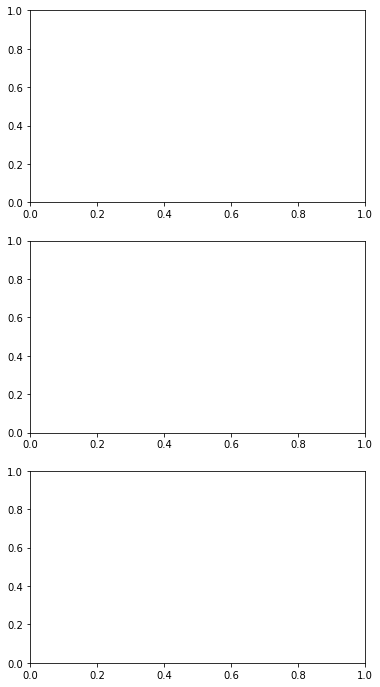

In [20]:
rels = [fc.ContactCorrelationHead, fc.ContactCorrelation]
labels = ['Head', 'Total']
colors = ['g', 'k']
conn = ['cont_shared_percent', 'syn_shared_percent', 'density_pearson_converted']

fig, ax = plt.subplots(3, 1, figsize=(6, 12))
    
for i in range(len(rels)):
    radsyncont_df = pd.DataFrame(((radtune.BestVonCorr & sig_unit_pairs) * 
                              rels[i].proj(*attrs, cont_seg_shared = 'n_seg_shared', cont_seg_union = 'n_seg_union', segment_id1 = 'segment_id', segment_id2 = 'segment_b')).fetch())
    radsyncont_df['bin_diff_pref_ori'] = ori_centers[(np.digitize(np.abs(radsyncont_df['diff_pref_ori']), ori_edges)) - 1]
    radsyncont_df['cont_shared_percent'] = radsyncont_df['cont_seg_shared'] / radsyncont_df['cont_seg_union']
    radsyncont_df['syn_intersect'] = radsyncont_df['n_seg_a_converted'] + radsyncont_df['n_seg_b_converted'] - radsyncont_df['n_seg_shared_converted']
    radsyncont_df['syn_shared_percent'] = radsyncont_df['syn_intersect'] / radsyncont_df['n_seg_shared_converted']
    
    for k in range(len(conn)):
        x_coords = ori_centers
        y_coords = radsyncont_df.groupby('bin_diff_pref_ori').mean()[conn[k]]

        ax[k].plot(x_coords, y_coords, label=labels[i], color=colors[i])
        errors = radsyncont_df.groupby('bin_diff_pref_ori').sem()[conn[k]]  # compute SE
        ax[k].errorbar(x_coords, y_coords, yerr=errors, ecolor=colors[i], fmt=' ', zorder=-1, label=None)
        ax[k].set_xticks(ori_centers)
        ax[k].set_xticklabels(['{}°-{}°'.format(*a) for a in ori_labels])
        ax[k].tick_params(labelsize=14)
        ax[k].set_xlabel(r'$\Delta \theta$', fontsize=16)
        ax[k].spines['top'].set_color('none')
        ax[k].spines['right'].set_color('none')
ax[0].set_ylabel(r'$\langle$Proportion Shared Contacts$\rangle$', fontsize=16)
ax[1].set_ylabel(r'$\langle$Proportion Shared Synapses$\rangle$', fontsize=16)
ax[2].set_ylabel(r'$\langle$Synapse Density Correlation$\rangle$', fontsize=16)
ax[0].legend(loc=9, frameon=False, fontsize=14)
fig.tight_layout()
fig.savefig('figures/cont_syn_density.png', dpi=300)

In [ ]:
# orientatin tuning 

rels = [fc.ContactCorrelationShaft, fc.ContactCorrelationHead, fc.ContactCorrelationSoma, fc.ContactCorrelationAxon]
labels = ['Shaft', 'Head', 'Soma', 'Axon']
colors = ['r', 'g', 'b', 'y']

fig, ax = plt.subplots(1, 1, figsize=(7, 5))
    
for i in range(len(rels)):
    radsyncont_df = pd.DataFrame(((radtune.BestVonCorr & sig_unit_pairs) * 
                              rels[i].proj(*attrs, cont_seg_shared = 'n_seg_shared', cont_seg_union = 'n_seg_union', segment_id1 = 'segment_id', segment_id2 = 'segment_b')).fetch())
    radsyncont_df['bin_diff_pref_ori'] = ori_centers[(np.digitize(np.abs(radsyncont_df['diff_pref_ori']), ori_edges)) - 1]
    
    x_coords = ori_centers
    y_coords = radsyncont_df.groupby('bin_diff_pref_ori').mean()['density_pearson_converted']
    
    ax.plot(x_coords, y_coords, label=labels[i], color=colors[i])

    errors = radsyncont_df.groupby('bin_diff_pref_ori').sem()['density_pearson_converted']  # compute SE
    ax.errorbar(x_coords, y_coords, yerr=errors, ecolor=colors[i], fmt=' ', zorder=-1, label=None)
    
ax.legend(frameon=False, loc=0, fontsize=12)
ax.tick_params(labelsize=12)
ax.spines['top'].set_color('none')
ax.spines['right'].set_color('none')
ax.set_xticks(ori_centers)
ax.set_xticklabels(['{}°-{}°'.format(*a) for a in ori_labels])
ax.set_xlabel(r'$\Delta \theta$', fontsize = 14)
ax.set_ylabel(r'$\langle$Synapse Density Correlation$\rangle$', fontsize = 14)
fig.savefig('figures/density_four_classes.png', dpi=300)

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(7, 5))
ax.plot(x_coords, y_coords, label=labels[i], color=colors[i])
errors = spatsyncont_df.groupby('bin_center_dist').sem()['density_pearson_converted']  # compute SE
ax.errorbar(x_coords, y_coords, yerr=errors, ecolor=colors[i], fmt=' ', zorder=-1, label=None)
    

In [ ]:
dist_labels

In [ ]:
spat_units = spattune.BestSTA.Loc & 'sta_snr > 1.5' & (segment & (spattune.BestSTA.Confidence() & tuned))
spat_unit_pairs = (spat_units.proj(segment_id1 = 'segment_id') * 
                  spat_units.proj(segment_id2 = 'segment_id')) & 'segment_id1 < segment_id2'

In [ ]:
# RF distance

rels = [ta3p100.ContactCorrelationShaft, ta3p100.ContactCorrelationHead, ta3p100.ContactCorrelationSoma, ta3p100.ContactCorrelationAxon]
labels = ['Shaft', 'Head', 'Soma', 'Axon']
colors = ['r', 'g', 'b', 'y']

#rels = [ta3p100.ContactCorrelation]
#labels = ['Total']
#colors = ['k']
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
    
for i in range(len(rels)):
    spatsyncont_df = pd.DataFrame(((spattune.BestSTACorr & sig_unit_pairs) * 
                              rels[i].proj(*attrs, cont_seg_shared = 'n_seg_shared', cont_seg_union = 'n_seg_union', segment_id1 = 'segment_id', segment_id2 = 'segment_b')).fetch())
    
    dist_edges = np.linspace(min(spatsyncont_df['center_dist']), max(spatsyncont_df['center_dist']), 8)
    de = list(['{:.1f}'.format(ee) for ee in dist_edges])
    dist_labels = list(zip(de[:-1], de[1:]))
    dist_centers = np.hstack((np.nan, np.round((np.array(dist_edges[1:]) + np.array(dist_edges[:-1]))/2, decimals=2), np.nan))
    spatsyncont_df['bin_center_dist'] = dist_centers[(np.digitize(spatsyncont_df['center_dist'], dist_edges))]
    
    x_coords = dist_centers[1:-1]
    y_coords = spatsyncont_df.groupby('bin_center_dist').mean()['density_pearson_converted']
    #print(x_coords, y_coords)
    ax.plot(x_coords, y_coords, label=labels[i], color=colors[i])
    #ax.scatter(x_coords, y_coords, label=labels[i], color=colors[i])

    errors = spatsyncont_df.groupby('bin_center_dist').sem()['density_pearson_converted']  # compute SE
    ax.errorbar(x_coords, y_coords, yerr=errors, ecolor=colors[i], fmt=' ', zorder=-1, label=None)
    
ax.legend(frameon=False, loc=0, fontsize=12)
ax.tick_params(labelsize=12)
ax.spines['top'].set_color('none')
ax.spines['right'].set_color('none')
ax.set_xticks(dist_centers[1:-1])
ax.set_xticklabels(['[{},{}]'.format(*a) for a in dist_labels], rotation=15)
ax.set_xlabel('RF distance', fontsize = 15)
ax.set_ylabel(r'$\langle$Synapse Density Correlation$\rangle$', fontsize = 15)
fig.savefig('figures/RFdistance_density_four_classes.png', dpi=300)

In [ ]:
# receptive field

functional = ['bin_center_dist']    
connectomics = ['cont_shared_percent', 'syn_shared_percent', 'binary_conversion_pearson',
       'binary_conversion_cosine', 'binary_conv_jaccard_ones_ratio',
       'binary_conv_jaccard_matching_ratio', 'conversion_pearson',
       'conversion_cosine', 'density_pearson', 'density_cosine',
       'synapse_volume_mean_pearson', 'synapse_volume_mean_cosine',
       'synapse_vol_density_pearson', 'synapse_vol_density_cosine',
       'binary_conversion_pearson_converted',
       'binary_conversion_cosine_converted',
       'binary_conv_jaccard_ones_ratio_converted',
       'binary_conv_jaccard_matching_ratio_converted',
       'conversion_pearson_converted', 'conversion_cosine_converted',
       'density_pearson_converted', 'density_cosine_converted',
       'synapse_volume_mean_pearson_converted',
       'synapse_volume_mean_cosine_converted',
       'synapse_vol_density_pearson_converted',
       'synapse_vol_density_cosine_converted']

with sns.axes_style('ticks'):
    fig, ax = plt.subplots(len(connectomics), len(functional), figsize=(5*len(functional), 3*len(connectomics)))

for i, pair in enumerate(itertools.product(functional, connectomics)):
    #sns.pointplot(pair[0], pair[1], data = spatsyncont_df, ax=ax[i], ci=None) 
    
    x_coords = dist_centers[1:-1]
    y_coords = spatsyncont_df.groupby(pair[0]).mean()[pair[1]] 
    ax[i].plot(x_coords, y_coords)
    
    errors = spatsyncont_df.groupby(pair[0]).sem()[pair[1]]  # compute SE
    ax[i].errorbar(x_coords, y_coords, yerr=errors, ecolor='k', fmt=' ', zorder=-1)
    
    ax[i].set_title(connectomics[i], fontsize=15)

sns.despine(trim=True)
fig.tight_layout()
fig.savefig('figures/Head_union_corr.png', dpi=100)

In [ ]:
# plot n_seg_shared/n_seg_union for both synapse and contact vs functional differences

functional = ['bin_diff_pref_ori', 'bin_diff_pref_dir', 'bin_von_corr']    
connectomics = ['cont_shared_percent', 'syn_shared_percent', 'binary_conversion_pearson',
       'binary_conversion_cosine', 'binary_conv_jaccard_ones_ratio',
       'binary_conv_jaccard_matching_ratio', 'conversion_pearson',
       'conversion_cosine', 'density_pearson', 'density_cosine',
       'synapse_volume_mean_pearson', 'synapse_volume_mean_cosine',
       'synapse_vol_density_pearson', 'synapse_vol_density_cosine',
       'binary_conversion_pearson_converted',
       'binary_conversion_cosine_converted',
       'binary_conv_jaccard_ones_ratio_converted',
       'binary_conv_jaccard_matching_ratio_converted',
       'conversion_pearson_converted', 'conversion_cosine_converted',
       'density_pearson_converted', 'density_cosine_converted',
       'synapse_volume_mean_pearson_converted',
       'synapse_volume_mean_cosine_converted',
       'synapse_vol_density_pearson_converted',
       'synapse_vol_density_cosine_converted']

with sns.axes_style('ticks'):
    fig, ax = plt.subplots(len(connectomics), len(functional), figsize=(5*len(functional), 3*len(connectomics)))

for i, pair in enumerate(itertools.product(functional, connectomics)):
    sns.pointplot(pair[0], pair[1], data = radsyncont_df, ax=ax[i%len(connectomics), i//len(connectomics)], ci=None) 
    
    # manually plot error bars
    x_coords = []
    y_coords = []
    for point_pair in ax[i%len(connectomics), i//len(connectomics)].collections:
        for x, y in point_pair.get_offsets():
            x_coords.append(x)
            y_coords.append(y)
    errors = radsyncont_df.groupby(pair[0]).sem()[pair[1]]  # compute SE
    
    ax[i%len(connectomics), i//len(connectomics)].errorbar(x_coords, y_coords, yerr=errors, ecolor='k', fmt=' ', zorder=-1)

for i in range(len(connectomics)):
    ax[i, 1].set_title(connectomics[i], fontsize=15)

#sns.pointplot('bin_diff_pref_ori', 'cont_shared_percent', ci=None, data = radsyncont_df, ax=ax[0,0], linestyles='--', color='k')    
#sns.pointplot('bin_diff_pref_dir', 'cont_shared_percent', ci=None, data = radsyncont_df, ax=ax[0,1], linestyles='--', color='k')    
#sns.pointplot('bin_von_corr', 'cont_shared_percent', ci=None, data = radsyncont_df, ax=ax[0,2], linestyles='--', color='k')    
#sns.pointplot('bin_diff_pref_ori', 'syn_shared_percent', ci=None, data = radsyncont_df, ax=ax[1,0], color='k')    
#sns.pointplot('bin_diff_pref_dir', 'syn_shared_percent', ci=None, data = radsyncont_df, ax=ax[1,1], color='k')    
#sns.pointplot('bin_von_corr', 'syn_shared_percent', ci=None, data = radsyncont_df, ax=ax[1,2], color='k')  
'''
l = ['Contact', 'Synapse']
for i in range(2):
    ax[i, 0].set_title('{} percent shared seg vs diff in orientation'.format(l[i]))
    ax[i, 0].set_xticklabels(['{}°-{}°'.format(*a) for a in ori_labels])
    ax[i, 0].set_xlabel(r'$\Delta \theta$')
    ax[i, 0].set_ylabel('$<Shared/Union>$')

    ax[i, 1].set_title('{} percent shared seg vs diff in direction'.format(l[i]))
    ax[i, 1].set_xticklabels(['{}°-{}°'.format(*a) for a in dir_labels])
    ax[i, 1].set_xlabel(r'$\Delta \theta$')
    ax[i, 1].set_ylabel('$<Shared/Union>$')

    ax[i, 2].set_title('{} percent shared seg vs von corr'.format(l[i]))
    ax[i, 2].set_xticklabels(['[{},{}]'.format(*a) for a in vc_labels])
    ax[i, 2].set_xlabel('Von corr')
    ax[i, 2].set_ylabel('$<Shared/Union>$')

'''
sns.despine(trim=True)
fig.tight_layout()
fig.savefig('figures/Head_confidence1.0_percent_shared_seg_by_functional_difference.png', dpi=100)